In [175]:
import pandas as pd
import numpy as np
import yfinance as yf

In [176]:
def get_data(stock):
    """
    This function queries a stock, drops unneeded columns, shifts the price down by a day and added a column labeled "Target" that determines if the next day price was higher for prediction.
    """
    df = yf.Ticker(stock)
    df = df.history(period="max")
    df.drop(columns=["Dividends", "Stock Splits", "Capital Gains"], inplace=True)
    df["Next_Day_Price"] = df["Close"].shift(-1)
    df["Target"] = (df["Next_Day_Price"] > df["Close"]).astype(int)
    return df

In [180]:
# Select SP500 stock ticker
spy = get_data("SPY")
spy

,Open,High,Low,Close,Volume,Next_Day_Price,Target
Date,,,,,,,
1993-01-29 00:00:00-05:00,24.959130,24.959130,24.834955,24.941391,1003200,25.118786,1
1993-02-01 00:00:00-05:00,24.959133,25.118786,24.959133,25.118786,480500,25.172012,1
1993-02-02 00:00:00-05:00,25.101055,25.189752,25.047837,25.172012,201300,25.438103,1
1993-02-03 00:00:00-05:00,25.207492,25.455842,25.189753,25.438103,529400,25.544544,1
1993-02-04 00:00:00-05:00,25.526805,25.597762,25.242977,25.544544,531500,25.526781,0
...,...,...,...,...,...,...,...
2023-11-06 00:00:00-05:00,435.470001,436.149994,433.679993,435.690002,67831700,436.929993,1
2023-11-07 00:00:00-05:00,435.690002,437.589996,434.510010,436.929993,64256100,437.250000,1
2023-11-08 00:00:00-05:00,437.549988,438.089996,434.869995,437.250000,61746000,433.839996,0


In [189]:
from sklearn.ensemble import RandomForestClassifier

"""
n_estimators = number of decisions tree to train
min_samples_split = the minimum number of samples required to split an internal node
random_state =  controls randomness of the sample
"""

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Select all rows except the last 100 as the training dataset
train = spy.iloc[:-100]

# Select only the last 100 rows as a test dataset
test = spy.iloc[-100:]

# Select columns to use for predictions
predictors = ["Open", "High", "Low", "Close", "Volume"]

# Train the model using the data
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [192]:
from sklearn.metrics import precision_score

# Make the prediction on the separated data
preds = model.predict(test[predictors])

# Convert predictions to a readable pandas series
preds = pd.Series(preds, index=test.index)

In [194]:
precision_score(test["Target"], preds)

0.5116279069767442

<Axes: xlabel='Date'>

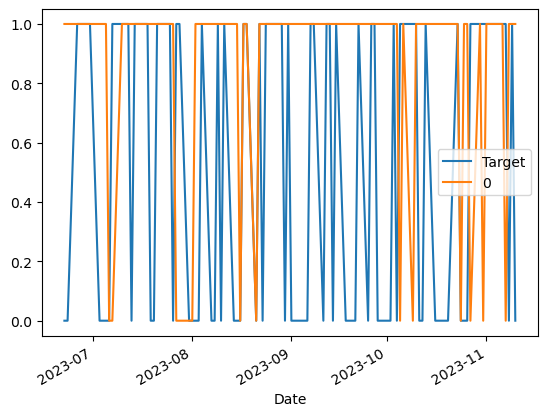

In [196]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [198]:
# Combine everything above into a function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [199]:
# Create a function to loop through all of the years
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [200]:
predictions = backtest(spy, model, predictors)

In [201]:
# See how many days predicted that the stock would rise vs fall
predictions["Predictions"].value_counts()

"""
0 = Market decline
1 = Market increase
"""

0    1515
1     685
Name: Predictions, dtype: int64

In [203]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5474452554744526

In [204]:
# Create a benchmark to see the percentage of days the stock has increased

predictions["Target"].value_counts() / predictions.shape[0]

1    0.52
0    0.48
Name: Target, dtype: float64